# Second tensorflow lab

We import all the libraries required for the exercises

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import binarize
from sklearn.preprocessing import StandardScaler

We download the yacht_hydrodynamics dataset from https://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics

The goal of this dataset is the prediction of residuary resistance of sailing yachts from a number of features.  Essential inputs include the basic hull dimensions and the boat velocity. 

This can be approached as a regression problem

In [4]:

# https://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics
data = np.loadtxt('yacht_hydrodynamics.data')
feature_names = ['Long. position', 'Prismatic coef.', 'LD ratio', 'BD ratio', 'LB ratio', 'Froude numb.', 'Resistance' ]

# The Pandas dataframe is created
df = pd.DataFrame(data,columns=feature_names)


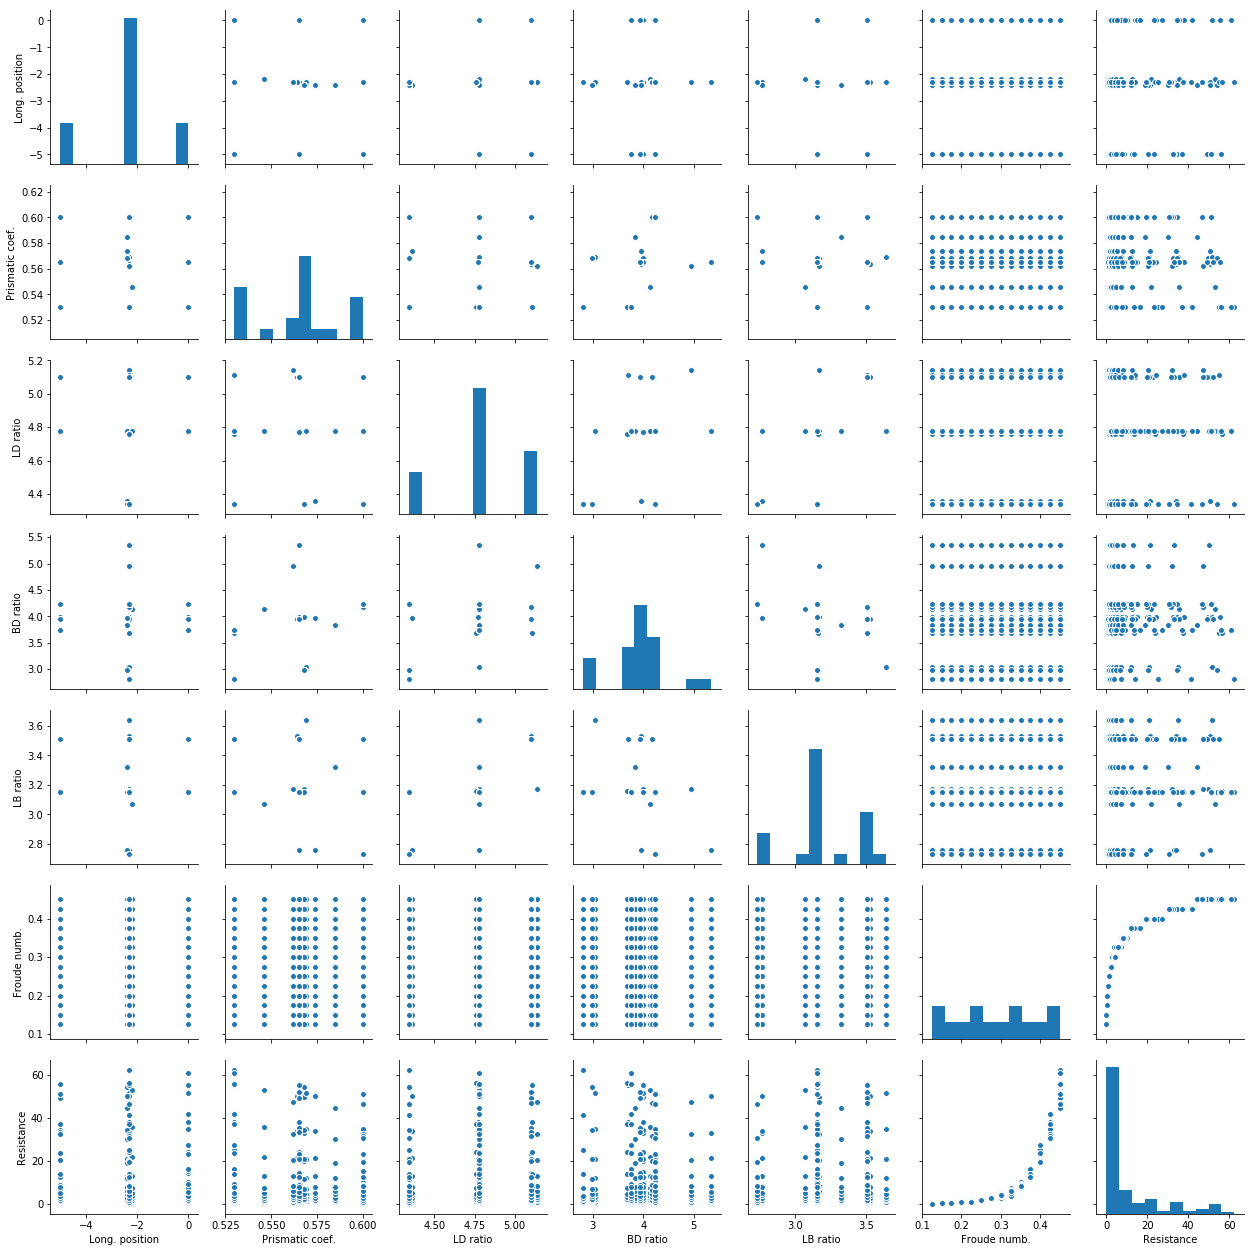

In [5]:
# Visualization of the dataset
sns.pairplot(df)
plt.show()

In [6]:
features = data[:,:-1]
target = data[:,-1]

# We split the data into two sets, training and test

train_features = features[::2,:]
train_target = target[::2]
train_n_samples = train_features.shape[0]

test_features = features[1::2,:]
test_target = target[1::2]
test_n_samples = test_features.shape[0]


In the first analysis we will only use one feature to model the response variable
We select the "best predictor" among the 16 voice features.


In [7]:
# The SelectKBest function from scikit-learn, with the f_regression metric, is used for feature selection
feature_selector = SelectKBest(f_regression, k=1)
feature_selector.fit(train_features, train_target)

# We print the index of the selected feature
print(np.argmax(feature_selector.scores_))

5


We plot the feature and the response variable to inspect the relationship between the two variables visually


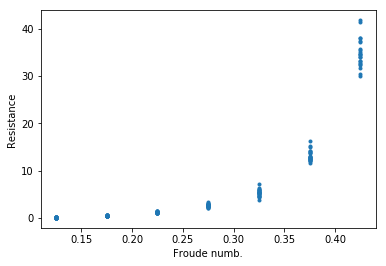

In [8]:
train_sel_feature = feature_selector.transform(train_features)
test_sel_feature = feature_selector.transform(test_features)
plt.plot(train_sel_feature,train_target,'.')
plt.xlabel(feature_names[np.argmax(feature_selector.scores_)])
plt.ylabel(feature_names[-1])
plt.show()

# Using tensorflow to learn a linear regression model

In [9]:
tf.reset_default_graph()
# We set the constant operators that will store the values of the 
# feature and response variable

X = tf.placeholder("float")
Y = tf.placeholder("float")

In [10]:
# The weights and bias are defined as variables. Notice that the definition is
# different to the one used above for the features and the target variable
# W and b will be initialized to zero.  By default, Variables are trainable.

W = tf.Variable(0.0, name="weight")
b = tf.Variable(0.0, name="bias")

In [11]:
# We define the linear model y = wx+b
# Notice that there is only one reponse variable and only one weight 

predicted = tf.add(tf.multiply(W, X), b)

In [12]:
# The loss function to use will be the mean squared error
loss = tf.reduce_sum(tf.keras.losses.MSE(Y, predicted))#tf.reduce_sum(tf.pow(predicted-Y, 2))/(train_n_samples)

In [13]:
# We define the parameters of the learning process 
learning_rate = 0.05

In [14]:
# The optimizer is the gradient descent
# It uses as input parameter the learning rate and the loss function
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


In [15]:
# Before starting the tensorflow session we need to initialize the parameters

init = tf.global_variables_initializer()

# Number of iterations for the learning algorithm
training_epochs = 10000
display_step = 5000
perm = np.random.permutation(train_n_samples)


There are three classes of gradient descent methods

- Batch gradient descent

- Stochastic gradient descent 

- Mini-batch gradient descent 


Below there is an example of Mini-batch gradient descent implemented with the classical gradient descent minimizer method.

After the model has been learned we plot the predictions in the test set. Uncomment the line where the prediction for the scikit-learn model is plotted in order to compare the prediction of the two algorithms. 

Epoch: 5000 cost= 21161.855468750 W= 3.6937 b= 7.27382
Epoch: 10000 cost= 21160.175781250 W= 3.5399 b= 7.28699
Training loss= 21160.2 W= 3.5399 b= 7.28699 



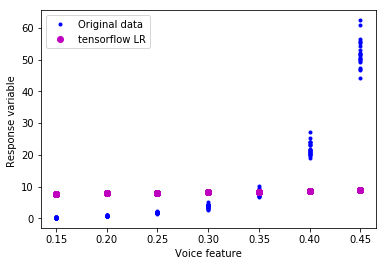

In [16]:
mini_batch_size = 6
n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
error = []
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
# Start training

# Run the initializer
sess.run(init)

# Fit the training data in the batches.
for epoch in range(training_epochs):
    i_batch = (epoch % n_batch)*mini_batch_size
    batch = train_sel_feature[i_batch:i_batch+mini_batch_size], train_target[i_batch:i_batch+mini_batch_size]

    sess.run(optimizer, feed_dict={X: batch[0], Y: batch[1]})

    #for (x, y) in zip(train_sel_feature[perm,:], train_target[perm]):
    #    sess.run(optimizer, feed_dict={X: x, Y: y})

    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        c = sess.run(loss, feed_dict={X: train_sel_feature, Y: train_target})

        error.append(c)        
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c),  "W=", sess.run(W), "b=", sess.run(b))



training_loss = sess.run(loss, feed_dict={X: train_sel_feature , Y: train_target})
print("Training loss=", training_loss, "W=", sess.run(W), "b=", sess.run(b), '\n')


# Visualization of the prediction for the test data
plt.plot(test_sel_feature, test_target, 'b.', label='Original data')
plt.plot(test_sel_feature, sess.run(W) * train_sel_feature + sess.run(b),'om', label='tensorflow LR')
#plt.plot(test_sel_feature,predicted_test_target,'vr', label='Scikit-learn LR')
plt.xlabel('Voice feature')
plt.ylabel('Response variable ')

plt.legend()
plt.show()
    
 

# Exercise 1 

a) Use tensorflow to learn the model y = a*x^2 + c*x + b where a,b, and c are the parameters of the model.

b) Train the model using two different stochastic gradient descent strategies and the Momentum optimizer



In [23]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

a = tf.Variable(0.0, name="weight_a")
b = tf.Variable(0.0, name="weight_b")
c = tf.Variable(0.0, name="bias")

# y = ax**2 + bx + c
predicted = tf.add(tf.multiply(a, tf.pow(X, 2)), tf.add(tf.multiply(b, X), c))
loss = tf.reduce_sum(tf.keras.losses.MSE(Y, predicted))  # tf.reduce_sum(tf.pow(predicted-Y, 2))/(train_n_samples)
learning_rate = 0.05
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

init = tf.global_variables_initializer()

# Number of iterations for the learning algorithm
training_epochs = 10000
display_step = 5000
perm = np.random.permutation(train_n_samples)


Epoch: 5000 cost= 21162.269531250 W= 0.0 b= 2.98554
Epoch: 10000 cost= 21161.652343750 W= 0.0 b= 2.39053
Training loss= 21161.7 W= 0.0 b= 2.39053 



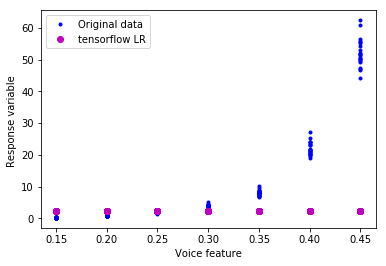

In [21]:
mini_batch_size = 6
n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
error = []
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
# Start training

# Run the initializer
sess.run(init)

# Fit the training data in the batches.
for epoch in range(training_epochs):
    i_batch = (epoch % n_batch)*mini_batch_size
    batch = train_sel_feature[i_batch:i_batch+mini_batch_size], train_target[i_batch:i_batch+mini_batch_size]

    sess.run(optimizer, feed_dict={X: batch[0], Y: batch[1]})

    #for (x, y) in zip(train_sel_feature[perm,:], train_target[perm]):
    #    sess.run(optimizer, feed_dict={X: x, Y: y})

    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        c = sess.run(loss, feed_dict={X: train_sel_feature, Y: train_target})

        error.append(c)        
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c),  "W=", sess.run(W), "b=", sess.run(b))



training_loss = sess.run(loss, feed_dict={X: train_sel_feature , Y: train_target})
print("Training loss=", training_loss, "W=", sess.run(W), "b=", sess.run(b), '\n')


# Visualization of the prediction for the test data
plt.plot(test_sel_feature, test_target, 'b.', label='Original data')
plt.plot(test_sel_feature, sess.run(W) * train_sel_feature + sess.run(b),'om', label='tensorflow LR')
#plt.plot(test_sel_feature,predicted_test_target,'vr', label='Scikit-learn LR')
plt.xlabel('Voice feature')
plt.ylabel('Response variable ')

plt.legend()
plt.show()
    
 

# Exercise 2

a) Use tensorflow to learn the model y = ax + c*z + b where are a,b, and c are the parameters of the model and x and z are the two most informative features among the 16 variables. 


b) Train the model using the batch gradient decent and the Adam optimizer.


# Exercise 3

a) Use tensorflow to learn the model y = WX + b where are W is a vector of 6 weights and X represents the six predictor variables.

Tip: Remember to use the tf.matmul (and np.matmul) function where necessary.

Now we are going to visualize the weights learned while optimizing the loss function. We firstly obtain them from the W tensor:

In [ ]:
optimized_weights = sess.run(W)
optimized_weights

Because the variables have different scales, the weights as they have been learned are not very informative. Think of a way of making the weight values interpretable.

### Multiple regression scenario

We now are going to make the problem a little more complex. We are going to add another variable to be predicted by the model. Because the model we are employing is linear, the target variable we are going to add is going to be a linear combination of the predictor variables in the database:

In [ ]:
new_target = 0.5*features[:, 0] - 3.5*features[:, 1] + 0.2*features[:, 2]  + 0.15*features[:, 3] - 0.4*features[:, 4] - 5.5*features[:, 5] + 2

# Exercise 4

Train the same linear model (y = WX + b), but in this case *y* is composed of two variables, target and new_target. 

Two approaches can be followed. Either the y placeholder receives two columns (y = WX + b), or *two y placeholders* need to be defined (y1 = W1X + b1, y2 = W2X + b2). The first one is preferred in this case, as it can be seen as a previous step to the following classes.

Print the learned weights. What shape does the weight matrix/matrices have? Why?

Can you find any correspondence between the weights corresponding to the prediction of the artificial target and the way it was created?